In [ ]:
# Ensure repo and src/ are importable and .env is loaded
import notebooks._bootstrap_src_path  # noqa: F401


# Retrieval Evaluation

In [ ]:
# Dependencies are managed via the repository's virtual environment.
# Install once from the project root using `requirements.txt`.
# This notebook intentionally avoids `%pip install` lines.

In [2]:
import os
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.dataclasses import ChatMessage
import importlib
from datetime import datetime
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import logging
from models import EmbeddingModelConfig, EmbeddingModelProvider, LLMConfig, LLMProvider, RewriterModelConfig
from pipelines.evaluation.base_retrieval_eval_pipeline import get_base_retrieval_eval_pipeline
logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logging.getLogger("haystack").setLevel(logging.WARNING)

os.environ["SENTENCE_TRANSFORMERS_HOME"] = "./model-assets/sentence-transformers"
os.environ["HF_HUB_CACHE"] = "./model-assets/hugging-face"


In [3]:
from config.secret import OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["LLM_CONTEXT_SIZE"] = "8192"

NUMBER_OF_QUESTIONS_IN_EVAL = 600
TOP_K = 10

In [4]:
test_configs = [
    {
        "name": "Embedding Model Open Source",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": None,
        "contextualizer_model": None,
        "rewriting_model": None,
    },
    {
        "name": "Embedding Model Closed Source",
        "embedding_model": EmbeddingModelConfig(name="text-embedding-3-large", provider=EmbeddingModelProvider.OPENAI),
        "reranking_model": None,
        "contextualizer_model": None,
        "rewriting_model": None,
    },
    {
        "name": "Document Context Model Open Source",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": None,
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, temperature=0.0),
        "rewriting_model": None,
    },
    {
        "name": "Document Context Model Closed Source",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": None,
        "contextualizer_model": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI, temperature=0.0),
        "rewriting_model": None,
    },
    {
        "name": "Rewriting Model Open Source",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": None,
        "contextualizer_model": None,
        "rewriting_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, temperature=0.0),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """
        ),
    },
    {
        "name": "Rewriting Model Closed Source",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": None,
        "contextualizer_model": None,
        "rewriting_model": RewriterModelConfig(
            LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI, temperature=0.0),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """
        ),
    },
]

In [5]:
now = datetime.now()

def run_retrieval_eval(filename, df):
    import config.prompt
    importlib.reload(config.prompt)

    import re

    match = re.search(r"answers_(.*?)_dataset", filename)
    if match:
        splitting_strategy = match.group(1)
    else:
        splitting_strategy = None

    # 1) Filter out the null‐question rows
    df_nonnull = df[df["question"].notnull()]

    df_shuffled = df_nonnull.sample(n=NUMBER_OF_QUESTIONS_IN_EVAL, random_state=42).reset_index(drop=True)

    for index, row in tqdm(
        df_shuffled.iterrows(),
        total=len(df_shuffled),
        desc="Processing rows",
        unit="row"
    ):
        for test_config in test_configs:
            relevant_documents = row["documents"]
            question = row["question"]

            if test_config["contextualizer_model"] != None:
                index_store = InMemoryDocumentStore.load_from_disk(f"data/document_stores/{test_config['embedding_model'].name}/context/{test_config['contextualizer_model'].name}/{splitting_strategy}_indexing_store.json")
            else:
                index_store = InMemoryDocumentStore.load_from_disk(f"data/document_stores/{test_config['embedding_model'].name}/base/{splitting_strategy}_indexing_store.json")
            pipeline = get_base_retrieval_eval_pipeline(index_store, test_config["embedding_model"], None, test_config["rewriting_model"])

            request_payload = {
                "retriever": {
                    "top_k": TOP_K,
                },
                "map_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                },
                "mrr_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                },
                "recall_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                }
            }
            previous_messages = [
                ChatMessage.from_user(msg) if idx == 0
                else ChatMessage.from_assistant(msg)
                for idx, msg in enumerate(row["prev_messages"])
            ]
            if "rewriter" in pipeline.graph.nodes:
                request_payload["rewriter"] = {
                    "query": question,
                    "previous_messages": previous_messages,
                }
            else:
                request_payload["query_embedder"] = {
                    "text": question,
                }
            result = pipeline.run(request_payload)

            map_score = result.get("map_evaluator", {}).get("score", {})
            mrr_score = result.get("mrr_evaluator", {}).get("score", {})
            recall_score = result.get("recall_evaluator", {}).get("score", {})

            df.at[index, f"{test_config['name']}_map"] = map_score
            df.at[index, f"{test_config['name']}_mrr"] = mrr_score
            df.at[index, f"{test_config['name']}_recall"] = recall_score

    save_path = f"results/retrieval/open_closed/{now.strftime('%Y-%m-%d_%H-%M-%S')}/open_closed_result.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_pickle(save_path)

run_retrieval_eval("data/qa_with_docs_flat/question_answers_docs_word_100_20_dataset_flat.pkl", pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_word_100_20_dataset_flat.pkl"))

Processing rows:   0%|          | 0/600 [00:00<?, ?row/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 1/600 [00:15<2:39:33, 15.98s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 2/600 [00:26<2:08:35, 12.90s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 2/600 [00:31<2:37:47, 15.83s/row]


KeyboardInterrupt: 

## Analysis

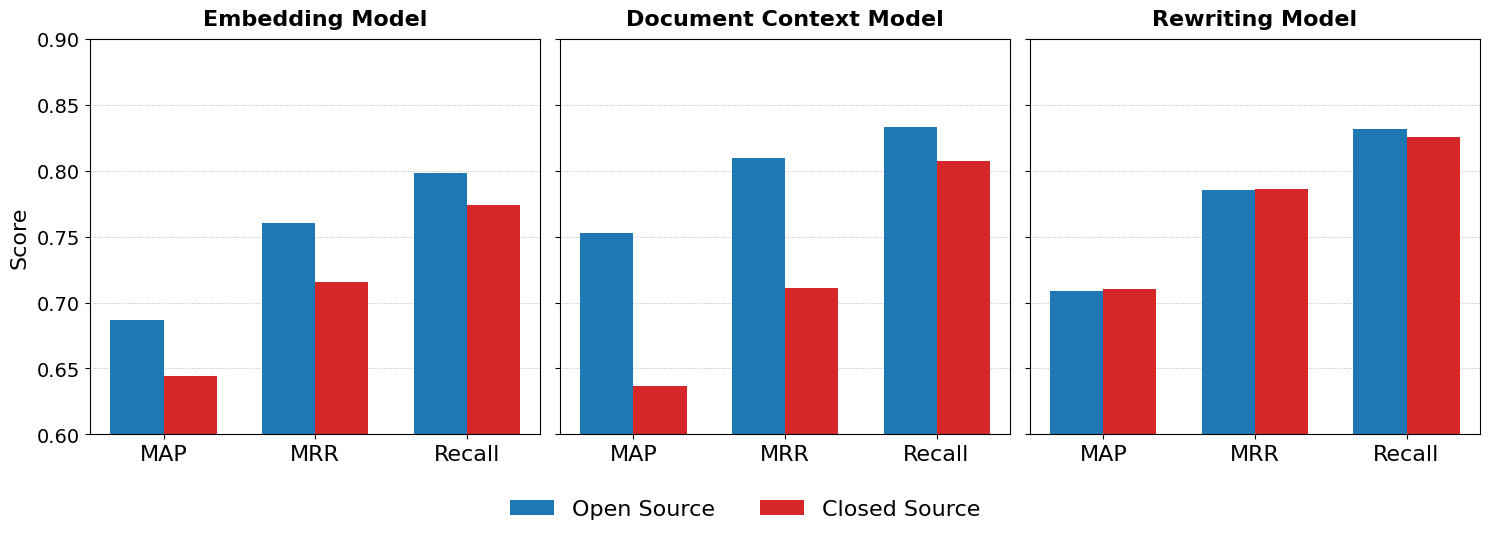

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # (still useful if styling is desired)
import numpy as np

# Load data
# (Adjust path if you have a different timestamp/result file you want to visualize)
df = pd.read_pickle("results/retrieval/open_closed/2025-08-12_13-48-18/open_closed_result.pkl")

# Setup
model_types = {
    "Embedding Model": "Embedding",
    "Document Context Model": "Document Context",
    "Rewriting Model": "Rewriting"
}
metrics = ["map", "mrr", "recall"]
metrics_upper = [m.capitalize() if m == "recall" else m.upper() for m in metrics]
source_types = ["Open Source", "Closed Source"]

OPEN_COLOR = "#1f77b4"      # Open models
CLOSED_COLOR = "#d62728"    # Closed models (matplotlib default red tone)

# Pre-compute min (ignoring NaNs) for optional dynamic y-limits if desired
all_vals = []
for model_key in model_types.keys():
    for metric in metrics:
        for source in source_types:
            col_name = f"{model_key} {source}_{metric}"  # e.g. "Embedding Model Open Source_map"
            if col_name in df.columns:
                val = df[col_name].mean()
                if not np.isnan(val):
                    all_vals.append(val)

# Fallback if list empty
if len(all_vals) == 0:
    all_vals = [0.0]

# Define y-axis bounds (original heatmap constrained to 0.5..1.0)
y_min = 0.6
y_max = 0.9

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

x = np.arange(len(metrics))
bar_width = 0.35

for ax, (model_key, model_label) in zip(axes, model_types.items()):
    open_vals = []
    closed_vals = []
    for metric in metrics:
        # Column naming pattern per earlier code
        open_col = f"{model_key} Open Source_{metric}"
        closed_col = f"{model_key} Closed Source_{metric}"
        open_mean = df[open_col].mean() if open_col in df.columns else np.nan
        closed_mean = df[closed_col].mean() if closed_col in df.columns else np.nan
        open_vals.append(open_mean)
        closed_vals.append(closed_mean)

    # Plot bars
    ax.bar(x - bar_width/2, open_vals, width=bar_width, color=OPEN_COLOR, label="Open Source")
    ax.bar(x + bar_width/2, closed_vals, width=bar_width, color=CLOSED_COLOR, label="Closed Source")

    # X-axis setup
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_upper, fontsize=16)
    ax.tick_params(axis='y', labelsize=14)

    # Y-axis
    ax.set_ylim(y_min, y_max)
    if model_key == "Embedding Model":
        ax.set_ylabel("Score", fontsize=16, labelpad=5)

    # Title
    ax.set_title(f"{model_label} Model", fontsize=16, fontweight='bold', pad=10)

    # Grid (horizontal for readability)
    ax.yaxis.grid(True, linestyle=':', linewidth=0.6, alpha=1)
    ax.set_axisbelow(True)

    # Annotate bars with values
    # for xpos, val in zip(x - bar_width/2, open_vals):
    #     if not np.isnan(val):
    #         ax.text(xpos, val + 0.005, f"{val:.3f}", ha='center', va='bottom', fontsize=9, color=OPEN_COLOR)
    # for xpos, val in zip(x + bar_width/2, closed_vals):
    #     if not np.isnan(val):
    #         ax.text(xpos, val + 0.005, f"{val:.3f}", ha='center', va='bottom', fontsize=9, color=CLOSED_COLOR)

# Legend (shared) – place only once
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
import pandas as pd

df = pd.read_pickle("results/retrieval/open_closed/2025-08-04_15-16-43/open_closed_result.pkl")

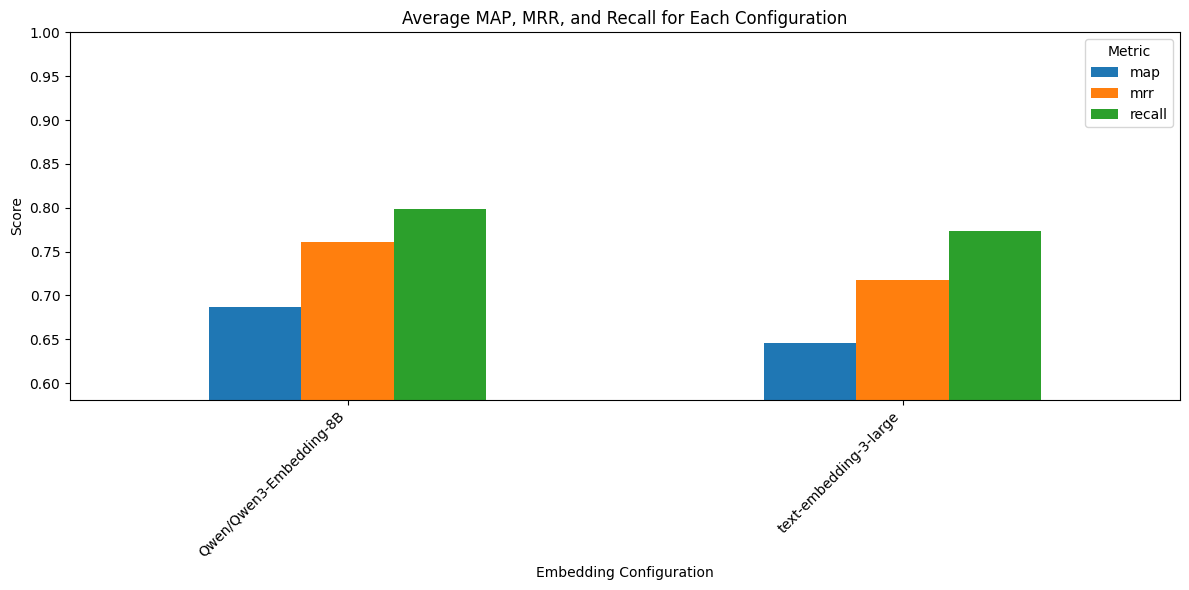

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Your DataFrame is assumed to be `df`
metric_prefixes = ['Qwen/Qwen3-Embedding-8B',
                   'text-embedding-3-large',]
metrics = ['map', 'mrr', 'recall']

# Build data dictionary
data = {}
for prefix in metric_prefixes:
    values = []
    for metric in metrics:
        col_name = f"{prefix}_{metric}"
        avg_value = df[col_name].mean()
        values.append(avg_value)
    data[prefix] = values

# Create DataFrame for plotting
metrics_df = pd.DataFrame(data, index=metrics)

# Find the minimum and maximum to scale y-axis
y_min = metrics_df.min().min()

# Plotting
ax = metrics_df.T.plot(kind='bar', figsize=(12, 6))
plt.title("Average MAP, MRR, and Recall for Each Configuration")
plt.ylabel("Score")
plt.xlabel("Embedding Configuration")
plt.xticks(rotation=45, ha='right')
plt.ylim(y_min * 0.9, 1.0)  # add some padding
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

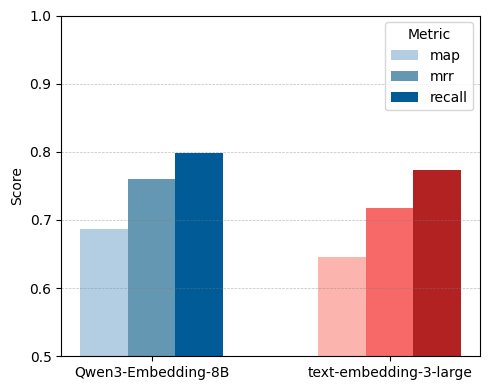

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- data prep ---
metric_prefixes = ['Qwen/Qwen3-Embedding-8B', 'text-embedding-3-large']
metrics = ['map', 'mrr', 'recall']

data = []
for prefix in metric_prefixes:
    model = 'Qwen3-Embedding-8B' if 'Qwen' in prefix else 'text-embedding-3-large'
    for metric in metrics:
        val = df[f"{prefix}_{metric}"].mean()
        data.append({'Model': model, 'Metric': metric, 'Score': val})

df_plot = pd.DataFrame(data)

# --- custom colors ---
qwen_colors = {
    'map': '#b3cde3',
    'mrr': '#6497b1',
    'recall': '#005b96'
}

text_colors = {
    'map': '#fbb4ae',
    'mrr': '#f76868',
    'recall': '#b22222'
}

colors = {'Qwen3-Embedding-8B': qwen_colors, 'text-embedding-3-large': text_colors}

# --- plotting ---
fig, ax = plt.subplots(figsize=(5, 4))
bar_width = 0.2
positions = {'Qwen3-Embedding-8B': 0, 'text-embedding-3-large': 1}

for i, metric in enumerate(metrics):
    for model in positions:
        xpos = positions[model] + (i - 1) * bar_width
        val = df_plot.query(f"Model == '{model}' and Metric == '{metric}'")["Score"].values[0]
        ax.bar(xpos, val,
               width=bar_width,
               color=colors[model][metric],
               label=metric if model == 'Qwen3-Embedding-8B' else None)  # label once
# Add horizontal dashed lines
for y in [0.6, 0.7, 0.8, 0.9]:
    ax.axhline(y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Axis setup
ax.set_xticks([0, 1])
ax.set_xticklabels(['Qwen3-Embedding-8B', 'text-embedding-3-large'])
ax.set_ylabel("Score")
ax.set_ylim(0.5, 1.0)
# ax.set_title("MAP, MRR, and Recall by Model")
ax.legend(title="Metric", loc='upper right')

plt.tight_layout()
plt.show()

/tmp/ipykernel_661832/1252074170.py:68: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


TypeError: tuple indices must be integers or slices, not str

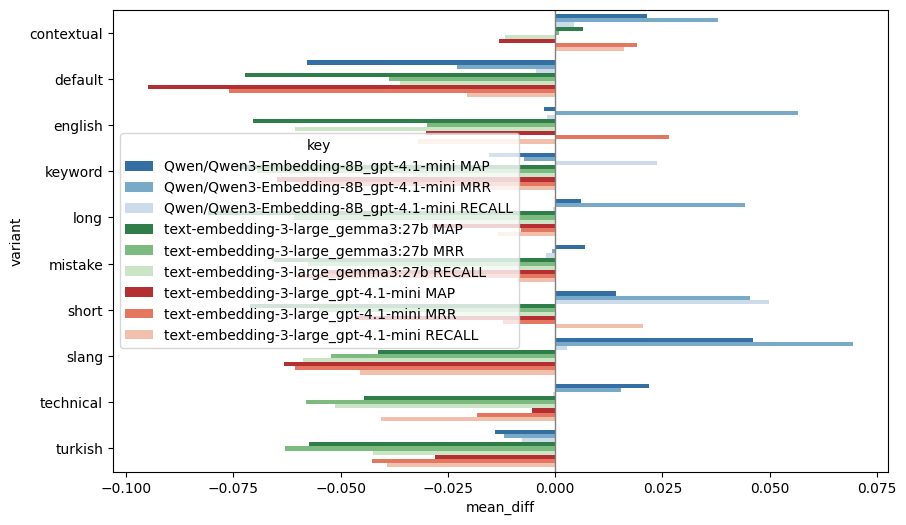

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_1samp

# ─── 0) assume `df` is loaded with columns:
#      'variant',
#      'Qwen/Qwen3-Embedding-4B_gemma3:12b_map',  …_mrr, …_recall,
#      'Qwen/Qwen3-Embedding-4B_gpt-4.1-mini_map', …,
#      'text-embedding-3-large_gemma3:12b_map', …,
#      'text-embedding-3-large_gpt-4.1-mini_map', …
# ────────────────────────────────────────────────────────────────────────────────

BASE    = 'Qwen/Qwen3-Embedding-8B_gemma3:27b'
CONFIGS = [
    'Qwen/Qwen3-Embedding-8B_gpt-4.1-mini',
    'text-embedding-3-large_gemma3:27b',
    'text-embedding-3-large_gpt-4.1-mini',
]
METRICS = ['map', 'mrr', 'recall']

# 1) compute per-row diffs for each config & metric
for cfg in CONFIGS:
    for m in METRICS:
        df[f'diff_{cfg}_{m}'] = (
            df[f'{cfg}_{m}'].astype(float)
          - df[f'{BASE}_{m}'].astype(float)
        )

# 2) aggregate by variant, metric & config, run t-test
records = []
for variant, grp in df.groupby('variant'):
    for cfg in CONFIGS:
        for m in METRICS:
            col = f'diff_{cfg}_{m}'
            vals = grp[col].dropna().astype(float)
            mean_diff = vals.mean()
            _, p = ttest_1samp(vals, 0)
            records.append({
                'variant':     variant,
                'config':      cfg,
                'metric':      m.upper(),
                'mean_diff':   mean_diff,
                'significant': p < 0.05
            })

summary = pd.DataFrame(records)

# 3) prepare for plotting: combine config+metric into one hue key
summary['key'] = summary['config'] + ' ' + summary['metric']

# 4) build a 3×3 palette: one sequential palette per config
pal = {}
# Blues for CONFIGS[0], Greens for CONFIGS[1], Reds for CONFIGS[2]
seqs = [sns.color_palette("Blues",3)[::-1],
        sns.color_palette("Greens",3)[::-1],
        sns.color_palette("Reds",3)[::-1]]
for cfg, seq in zip(CONFIGS, seqs):
    for col_idx, m in enumerate(['MAP','MRR','RECALL']):
        pal[f"{cfg} {m}"] = seq[col_idx]

hue_order = [f"{cfg} {m}" for cfg in CONFIGS for m in ['MAP','MRR','RECALL']]
variants  = sorted(summary['variant'].unique())

# 5) draw the barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=summary,
    y='variant',
    x='mean_diff',
    hue='key',
    hue_order=hue_order,
    palette=pal,
    order=variants,
    ci=None
)

# zero line
ax.axvline(0, color='gray', linewidth=1)

# annotate significance stars
sig_map = {
    (r.variant, r['config'], r['metric']): r.significant
    for r in summary.itertuples()
}
for hue_idx, container in enumerate(ax.containers):
    key = hue_order[hue_idx]            # e.g. "text-embedding-3-large_gemma3:12b RECALL"
    cfg, metr = key.rsplit(' ',1)
    for bar_idx, bar in enumerate(container.patches):
        variant = variants[bar_idx]
        if not sig_map.get((variant, cfg, metr), False):
            continue
        x = bar.get_width()
        y = bar.get_y() + bar.get_height()/2
        dx = 3 if x >= 0 else -3
        ax.annotate(
            "✱",
            xy=(x,y),
            xytext=(dx,0),
            textcoords="offset points",
            ha="left" if x>=0 else "right",
            va="center",
            fontsize=6
        )

ax.set_title("Mean MAP/MRR/Recall Difference vs. Qwen/Qwen3-Embedding-4B_gemma3:12b\n(by Variant)")
ax.set_xlabel("Mean Score Difference")
ax.set_ylabel("Variant")
ax.legend(title="", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()